In [12]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_basic_statistics(df):
    """
    Calculate Mean, Median, Mode, and Percentiles for Each Attribute
    """
    print("STATISTICAL MEASURES FOR CUSTOMER CHURN RECORDS")
    print("=" * 60)

    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    print(f"\nDataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Numerical Attributes: {len(numerical_cols)}")
    print(f"Categorical Attributes: {len(categorical_cols)}")

    # Process numerical attributes
    if numerical_cols:
        print(f"\nNUMERICAL ATTRIBUTES:")
        print("-" * 40)

        for col in numerical_cols:
            print(f"\n{col}:")
            data = df[col].dropna()

            if len(data) == 0:
                print("  No valid data")
                continue

            # Calculate basic statistics
            mean_val = data.mean()
            median_val = data.median()

            # Mode calculation
            try:
                mode_result = stats.mode(data, keepdims=True)
                mode_val = mode_result.mode[0]
            except:
                mode_val = "No unique mode"

            # Percentiles (25th, 50th, 75th, 90th, 95th)
            percentiles = [25, 50, 75, 90, 95]
            percentile_values = [data.quantile(p/100) for p in percentiles]

            # Display results
            print(f"  Mean:         {mean_val:.2f}")
            print(f"  Median:       {median_val:.2f}")
            print(f"  Mode:         {mode_val}")
            print(f"  Percentiles:")
            for i, p in enumerate(percentiles):
                print(f"    {p}th:       {percentile_values[i]:.2f}")

    # Process categorical attributes
    if categorical_cols:
        print(f"\nCATEGORICAL ATTRIBUTES:")
        print("-" * 40)

        for col in categorical_cols:
            print(f"\n{col}:")
            data = df[col].dropna()

            if len(data) == 0:
                print("  No valid data")
                continue

            # For categorical data, we can calculate mode and frequency percentiles
            value_counts = data.value_counts()
            mode_val = value_counts.index[0]
            mode_freq = value_counts.iloc[0]
            total_count = len(data)
            mode_percentage = (mode_freq / total_count) * 100

            print(f"  Mode:         {mode_val}")
            print(f"  Mode freq:    {mode_freq} ({mode_percentage:.1f}%)")
            print(f"  Unique vals:  {data.nunique()}")

            # Show top values (like percentiles for categorical)
            print(f"  Top values:")
            for i, (value, count) in enumerate(value_counts.head(3).items()):
                percentage = (count / total_count) * 100
                print(f"    {value}: {count} ({percentage:.1f}%)")

def main():
    """
    Load data and perform basic statistical analysis
    """
    try:
        # Load the CSV file
        df = pd.read_csv("Customer-Churn-Records.csv")
        print(f"Data loaded successfully!")

        # Perform statistical analysis
        calculate_basic_statistics(df)

    except FileNotFoundError:
        print("Error: Could not find 'Customer-Churn-Records.csv'")
        print("Make sure the file is in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Data loaded successfully!
STATISTICAL MEASURES FOR CUSTOMER CHURN RECORDS

Dataset Shape: 10000 rows, 18 columns
Numerical Attributes: 14
Categorical Attributes: 4

NUMERICAL ATTRIBUTES:
----------------------------------------

RowNumber:
  Mean:         5000.50
  Median:       5000.50
  Mode:         1
  Percentiles:
    25th:       2500.75
    50th:       5000.50
    75th:       7500.25
    90th:       9000.10
    95th:       9500.05

CustomerId:
  Mean:         15690940.57
  Median:       15690738.00
  Mode:         15565701
  Percentiles:
    25th:       15628528.25
    50th:       15690738.00
    75th:       15753233.75
    90th:       15790830.70
    95th:       15803034.30

CreditScore:
  Mean:         650.53
  Median:       652.00
  Mode:         850
  Percentiles:
    25th:       584.00
    50th:       652.00
    75th:       718.00
    90th:       778.00
    95th:       812.00

Age:
  Mean:         38.92
  Median:       37.00
  Mode:         37
  Percentiles:
    25th:       

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import normaltest, kstest, poisson, binom

def identify_best_distribution(df):
    """
    Identify the best suitable distribution (Gaussian, binomial, or Poisson) for numerical data.
    """
    print("DISTRIBUTION IDENTIFICATION FOR CUSTOMER CHURN RECORDS")
    print("=" * 60)

    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

    for col in numerical_cols:
        print(f"\nAnalyzing Column: {col}")
        data = df[col].dropna()

        if len(data) == 0:
            print("  No valid data for this column.")
            continue

        # Calculate basic statistics
        mean_val = data.mean()
        variance_val = data.var()
        std_val = data.std()

        print(f"  Mean: {mean_val:.2f}")
        print(f"  Variance: {variance_val:.2f}")
        print(f"  Std Dev: {std_val:.2f}")

        # Test results storage
        test_results = {}

        # 1. Test for Gaussian (Normal) distribution
        try:
            stat, p_normal = normaltest(data)
            test_results['Gaussian'] = p_normal
            print(f"  Gaussian test p-value: {p_normal:.4f}")
        except:
            test_results['Gaussian'] = 0
            print(f"  Gaussian test: Failed")

        # 2. Test for Poisson distribution
        try:
            # For Poisson, mean should approximately equal variance
            if mean_val > 0:
                poisson_dist = poisson(mean_val)
                ks_stat, p_poisson = kstest(data, poisson_dist.cdf)
                test_results['Poisson'] = p_poisson
                print(f"  Poisson test p-value: {p_poisson:.4f}")

                # Additional check: mean ≈ variance for Poisson
                ratio = variance_val / mean_val if mean_val > 0 else float('inf')
                print(f"  Variance/Mean ratio: {ratio:.2f} (Poisson ideal: ~1.0)")
            else:
                test_results['Poisson'] = 0
                print(f"  Poisson test: Not applicable (mean <= 0)")
        except:
            test_results['Poisson'] = 0
            print(f"  Poisson test: Failed")

        # 3. Test for Binomial distribution
        try:
            # Estimate parameters for binomial
            if data.min() >= 0 and data.max() <= 100:  # Reasonable range for binomial
                n_est = int(data.max())
                p_est = mean_val / n_est if n_est > 0 else 0.5

                if 0 <= p_est <= 1:
                    binom_dist = binom(n_est, p_est)
                    ks_stat, p_binomial = kstest(data, binom_dist.cdf)
                    test_results['Binomial'] = p_binomial
                    print(f"  Binomial test p-value: {p_binomial:.4f}")
                    print(f"  Estimated n: {n_est}, p: {p_est:.3f}")
                else:
                    test_results['Binomial'] = 0
                    print(f"  Binomial test: Invalid parameters")
            else:
                test_results['Binomial'] = 0
                print(f"  Binomial test: Data range not suitable")
        except:
            test_results['Binomial'] = 0
            print(f"  Binomial test: Failed")

        # Determine best distribution
        best_dist = max(test_results, key=test_results.get)
        best_p_value = test_results[best_dist]

        print(f"\n  BEST FIT DISTRIBUTION: {best_dist}")
        if best_p_value > 0.05:
            print(f"  ✓ Strong evidence (p > 0.05): {best_p_value:.4f}")
        elif best_p_value > 0.01:
            print(f"  ~ Moderate evidence (p > 0.01): {best_p_value:.4f}")
        else:
            print(f"  ✗ Weak evidence (p <= 0.01): {best_p_value:.4f}")

def main():
    """
    Load data and identify the best suitable distribution.
    """
    try:
        # Load the CSV file
        df = pd.read_csv("Customer-Churn-Records.csv")
        print("Data loaded successfully!")
        print(f"Dataset shape: {df.shape}")

        # Identify the best distribution
        identify_best_distribution(df)

    except FileNotFoundError:
        print("Error: Could not find 'Customer-Churn-Records.csv'")
        print("Make sure the file is in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Data loaded successfully!
Dataset shape: (10000, 18)
DISTRIBUTION IDENTIFICATION FOR CUSTOMER CHURN RECORDS

Analyzing Column: RowNumber
  Mean: 5000.50
  Variance: 8334166.67
  Std Dev: 2886.90
  Gaussian test p-value: 0.0000
  Poisson test p-value: 0.0000
  Variance/Mean ratio: 1666.67 (Poisson ideal: ~1.0)
  Binomial test: Data range not suitable

  BEST FIT DISTRIBUTION: Gaussian
  ✗ Weak evidence (p <= 0.01): 0.0000

Analyzing Column: CustomerId
  Mean: 15690940.57
  Variance: 5174814873.89
  Std Dev: 71936.19
  Gaussian test p-value: 0.0000
  Poisson test p-value: 0.0000
  Variance/Mean ratio: 329.80 (Poisson ideal: ~1.0)
  Binomial test: Data range not suitable

  BEST FIT DISTRIBUTION: Gaussian
  ✗ Weak evidence (p <= 0.01): 0.0000

Analyzing Column: CreditScore
  Mean: 650.53
  Variance: 9341.86
  Std Dev: 96.65
  Gaussian test p-value: 0.0000
  Poisson test p-value: 0.0000
  Variance/Mean ratio: 14.36 (Poisson ideal: ~1.0)
  Binomial test: Data range not suitable

  BEST FIT 

Data loaded successfully!
Dataset shape: (10000, 18)
AUTOMATIC CHART GENERATION FOR DATA VISUALIZATION

Analyzing Column: RowNumber
  Data Characteristics:
    Unique values: 10000
    Skewness: 0.00
    Outliers: 0 (0.0%)
  Best Chart Type: HISTOGRAM

Analyzing Column: CustomerId
  Data Characteristics:
    Unique values: 10000
    Skewness: 0.00
    Outliers: 0 (0.0%)
  Best Chart Type: HISTOGRAM

Analyzing Column: CreditScore
  Data Characteristics:
    Unique values: 460
    Skewness: -0.07
    Outliers: 15 (0.1%)
  Best Chart Type: HISTOGRAM

Analyzing Column: Age
  Data Characteristics:
    Unique values: 70
    Skewness: 1.01
    Outliers: 359 (3.6%)
  Best Chart Type: BOX_PLOT

Analyzing Column: Tenure
  Data Characteristics:
    Unique values: 11
    Skewness: 0.01
    Outliers: 0 (0.0%)
  Best Chart Type: HISTOGRAM

Analyzing Column: Balance
  Data Characteristics:
    Unique values: 6382
    Skewness: -0.14
    Outliers: 0 (0.0%)
  Best Chart Type: HISTOGRAM

Analyzing Colum

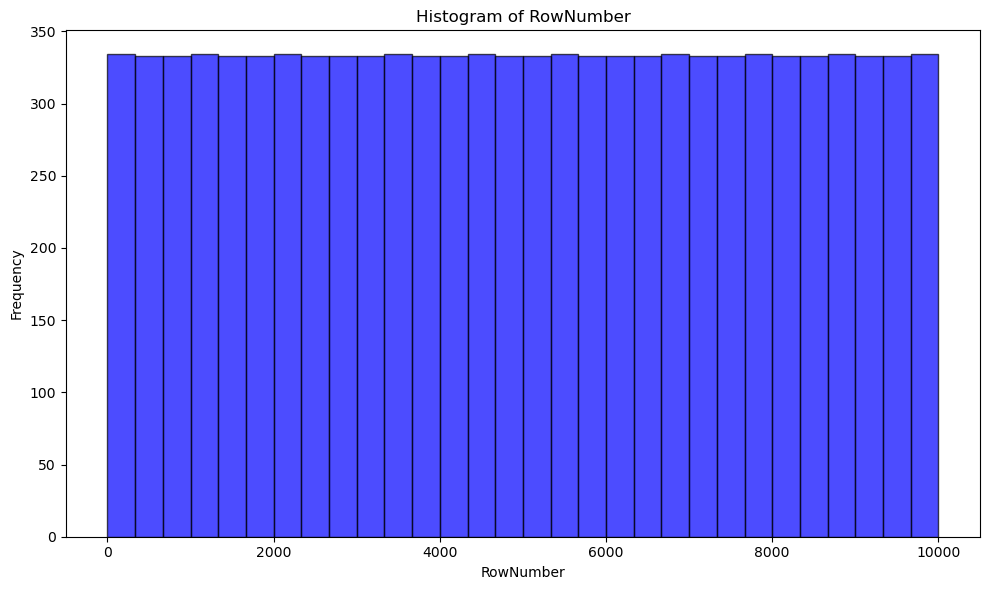

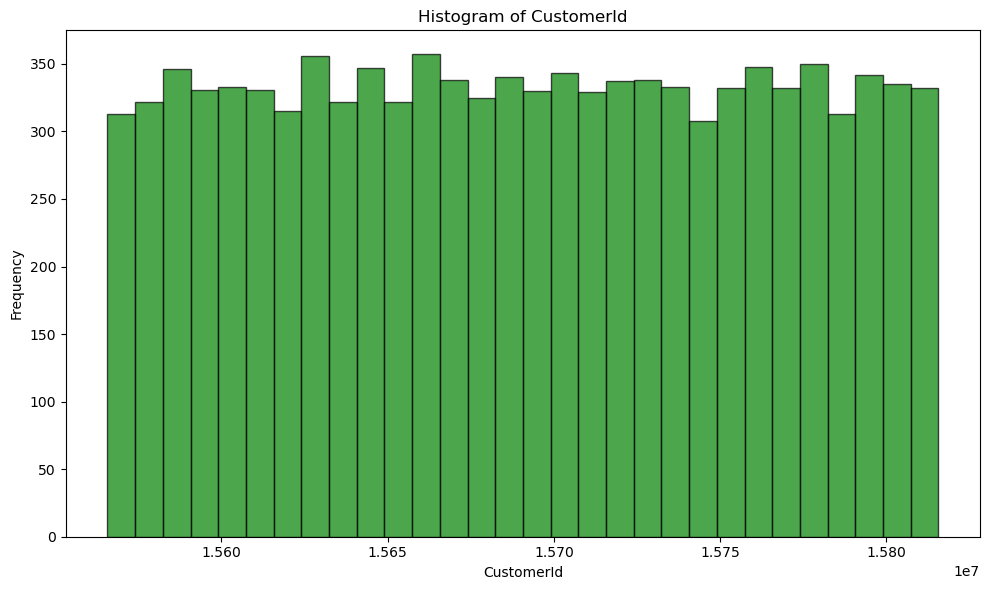

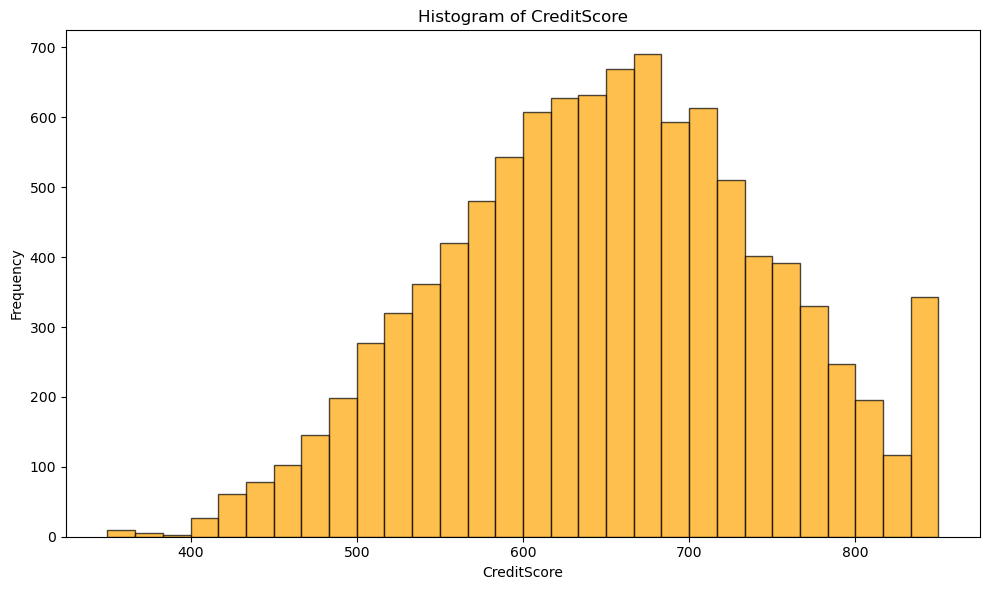

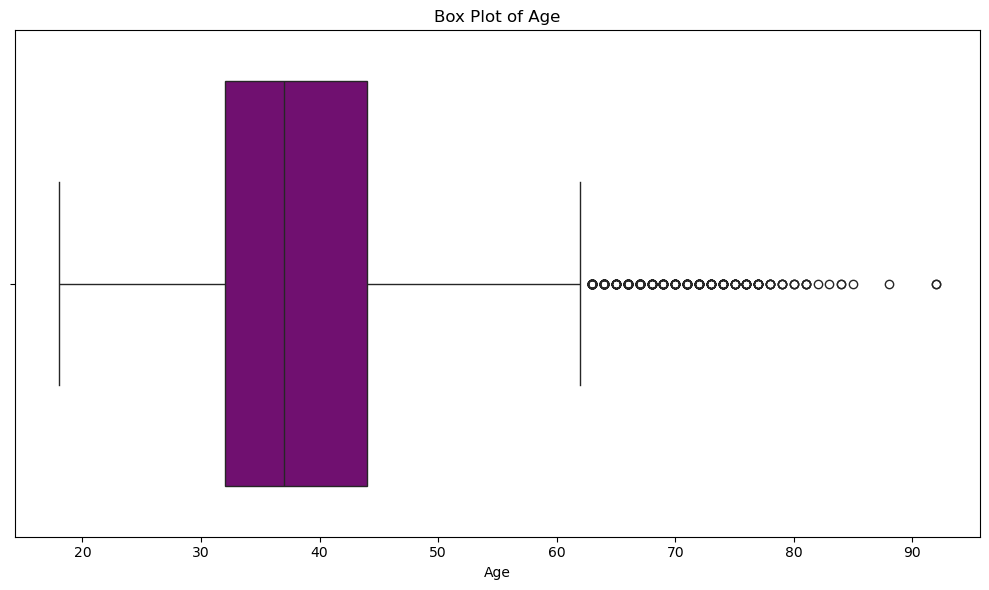

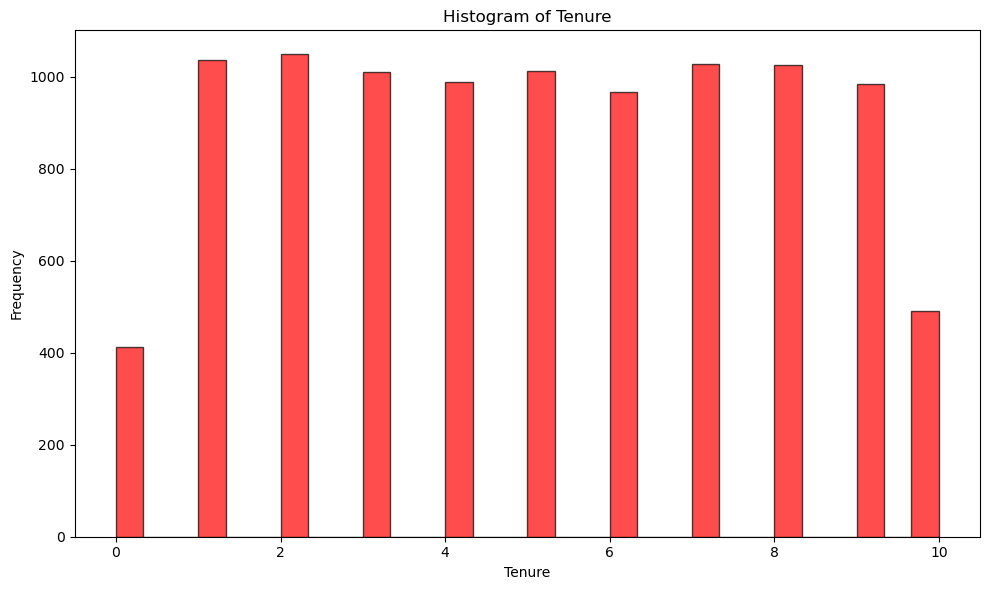

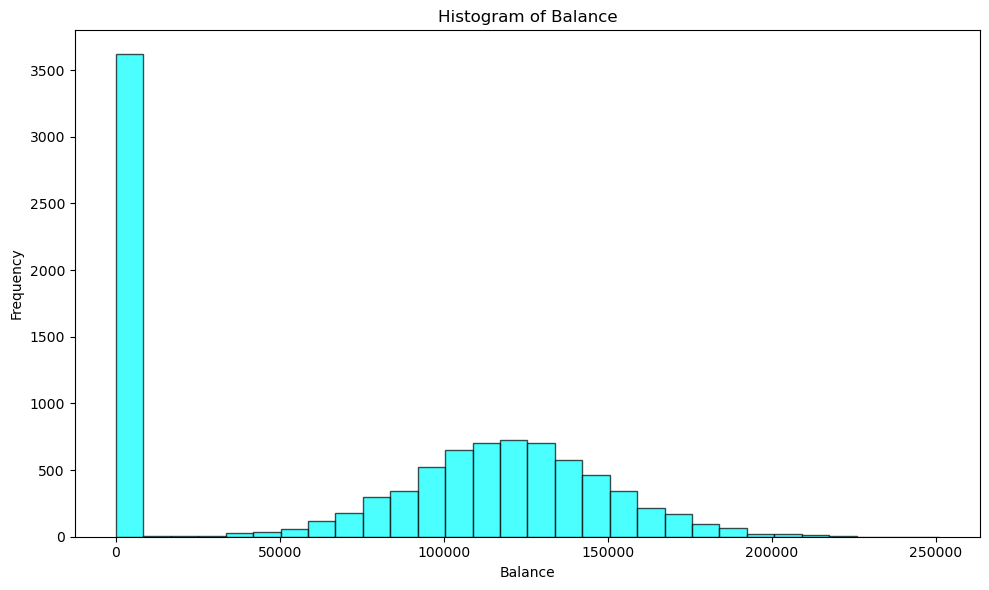

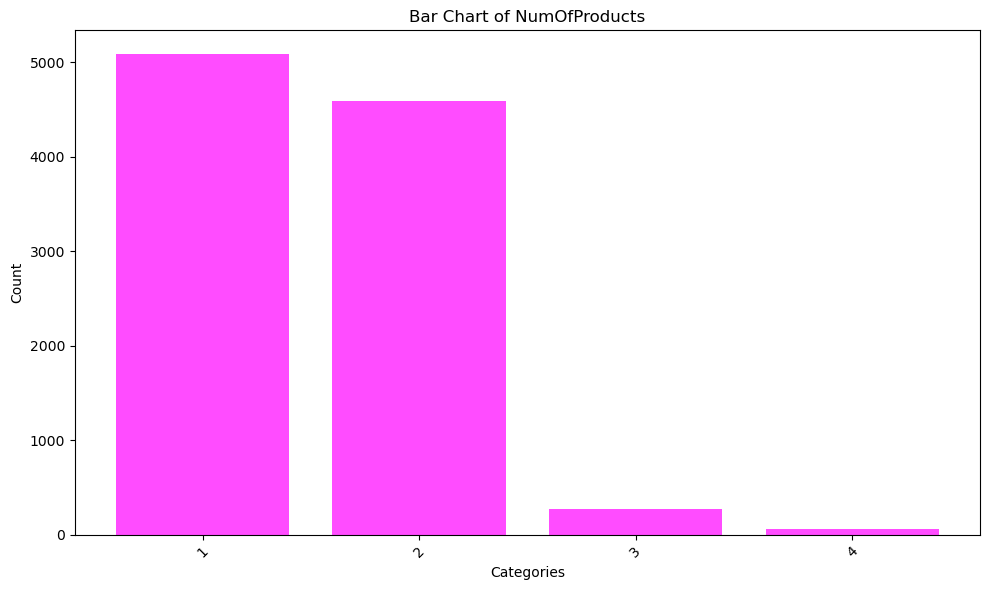

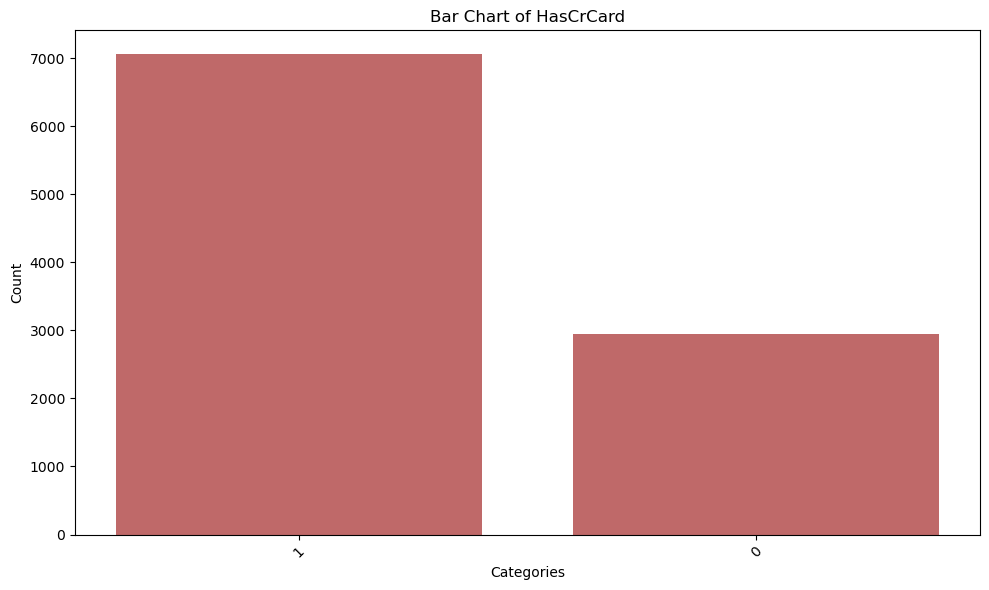

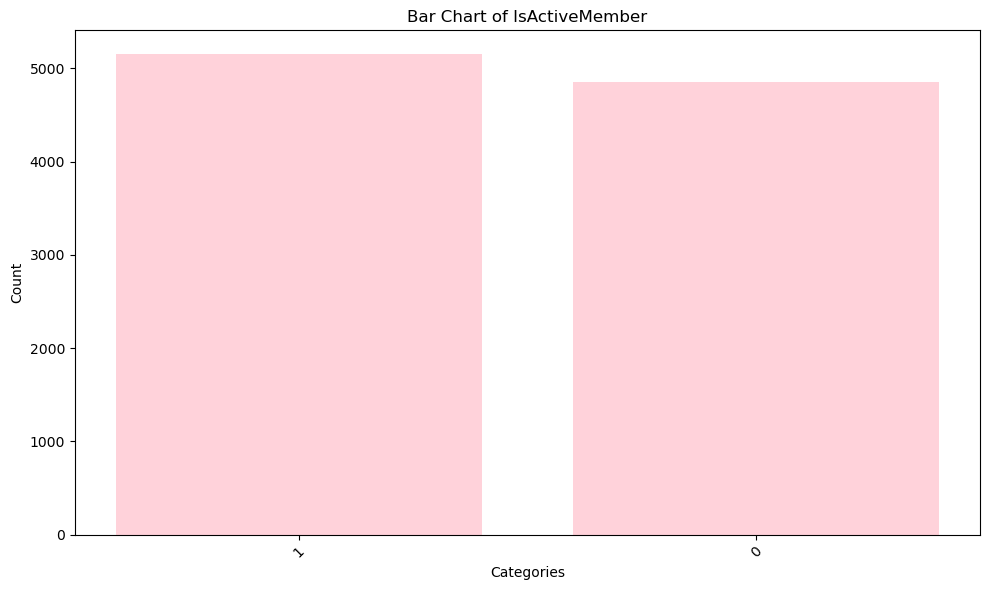

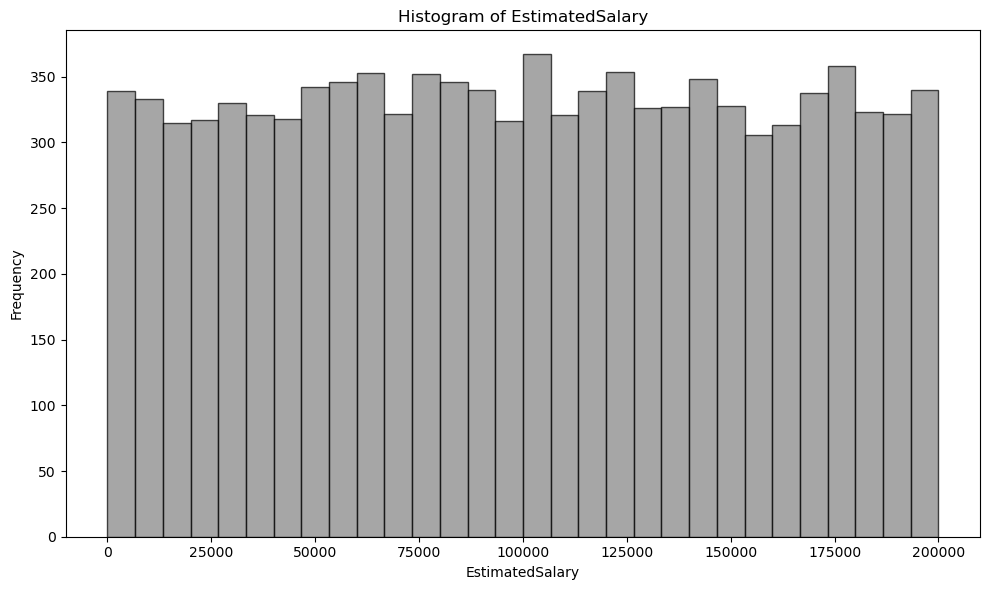

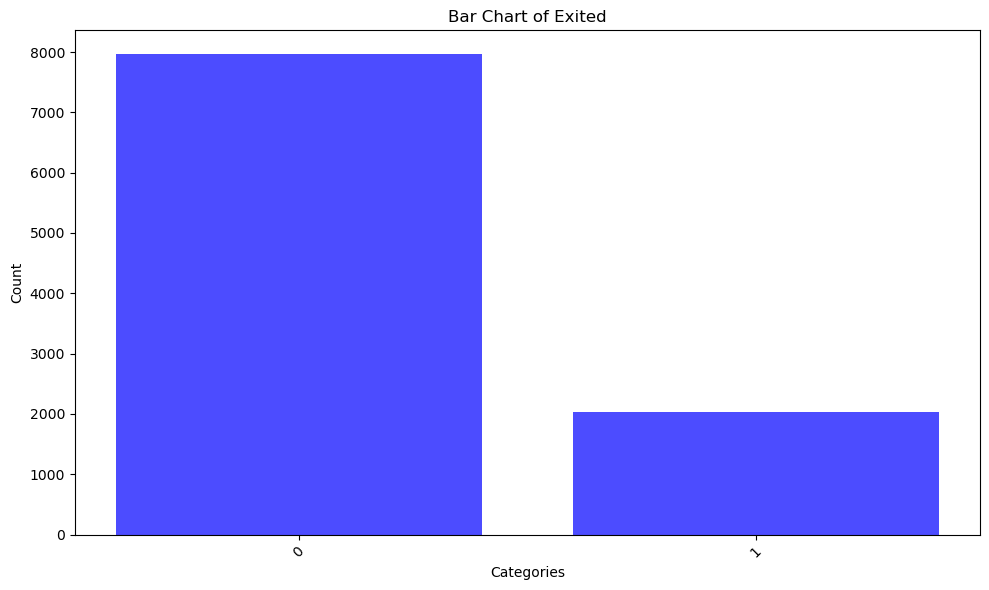

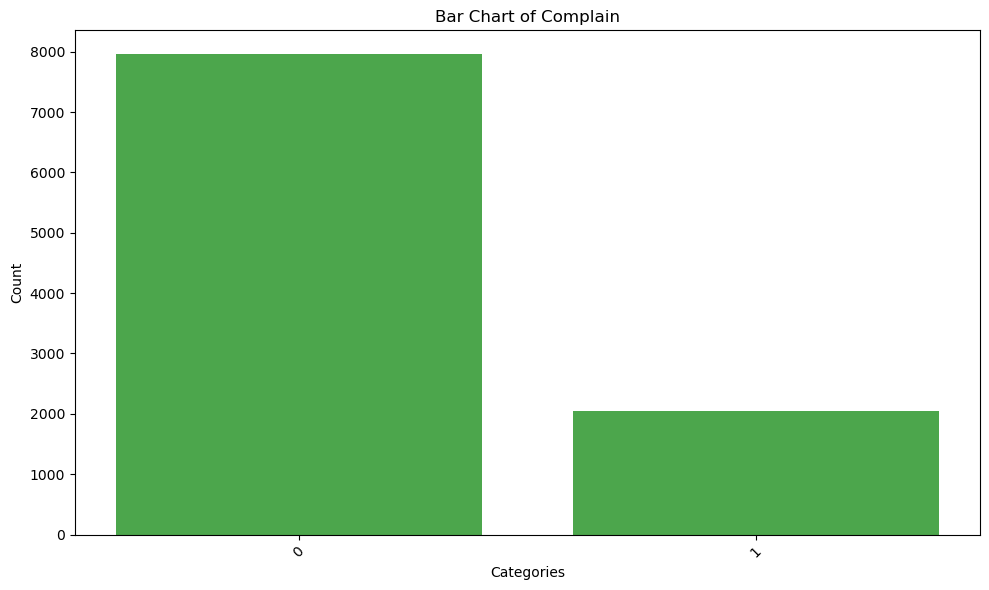

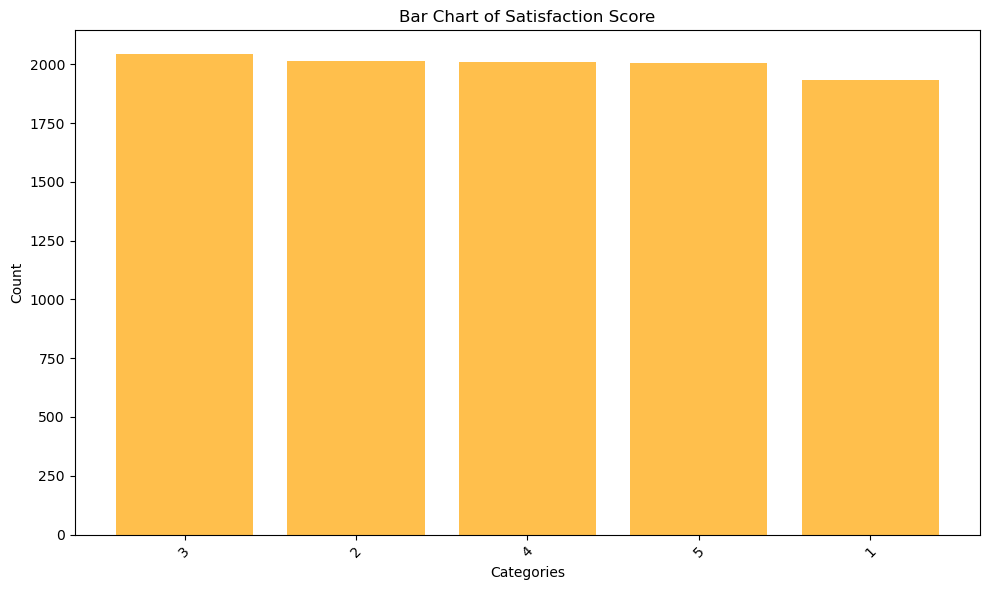

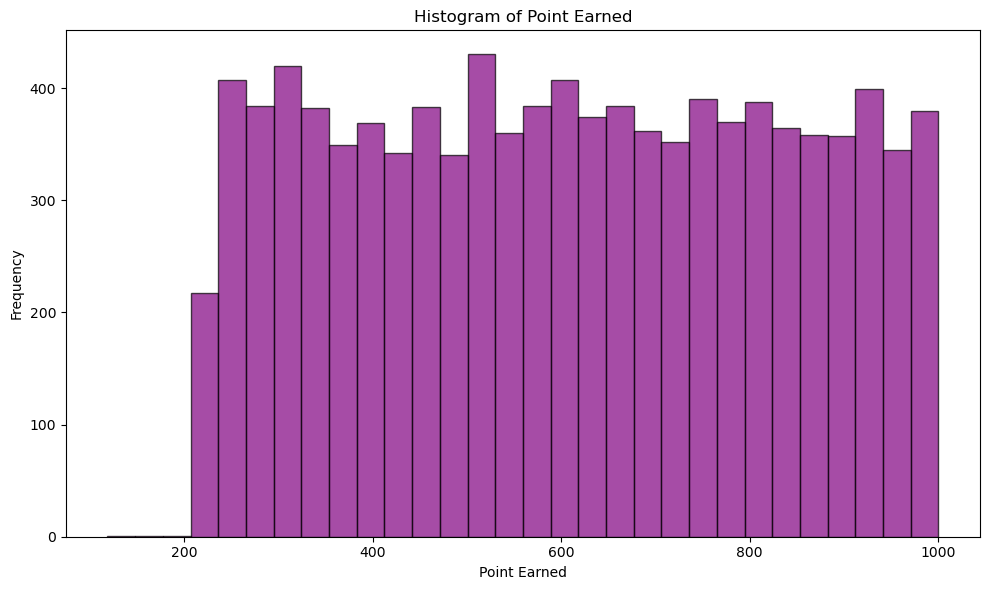

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def choose_best_chart(data, col_name):
    """
    Choose the best chart type based on data characteristics.
    """
    # Calculate data characteristics
    unique_values = data.nunique()
    skewness = abs(data.skew())
    outlier_ratio = len(data[(data < data.quantile(0.25) - 1.5 * (data.quantile(0.75) - data.quantile(0.25))) | 
                             (data > data.quantile(0.75) + 1.5 * (data.quantile(0.75) - data.quantile(0.25)))]) / len(data)
    
    # Decision logic for best chart
    if unique_values <= 10:  # Categorical-like data
        return "bar_chart"
    elif outlier_ratio > 0.1:  # More than 10% outliers
        return "box_plot"
    elif skewness > 1:  # Highly skewed data
        return "box_plot"
    else:  # Normal-ish distribution
        return "histogram"

def generate_chart(data, col_name, chart_type, color):
    """
    Generate the specified chart type for the data.
    """
    plt.figure(figsize=(10, 6))
    
    if chart_type == "histogram":
        plt.hist(data, bins=30, color=color, alpha=0.7, edgecolor='black')
        plt.title(f"Histogram of {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Frequency")
        
    elif chart_type == "box_plot":
        sns.boxplot(x=data, color=color)
        plt.title(f"Box Plot of {col_name}")
        plt.xlabel(col_name)
        
    elif chart_type == "bar_chart":
        value_counts = data.value_counts().head(10)  # Top 10 values
        plt.bar(range(len(value_counts)), value_counts.values, color=color, alpha=0.7)
        plt.title(f"Bar Chart of {col_name}")
        plt.xlabel("Categories")
        plt.ylabel("Count")
        plt.xticks(range(len(value_counts)), value_counts.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

def visualize_data_distributions(df):
    """
    Automatically choose and generate the best charts for data visualization.
    """
    print("AUTOMATIC CHART GENERATION FOR DATA VISUALIZATION")
    print("=" * 60)
    
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta', 'brown', 'pink', 'gray']
    
    for i, col in enumerate(numerical_cols):
        print(f"\nAnalyzing Column: {col}")
        data = df[col].dropna()
        
        if len(data) == 0:
            print("  No valid data for this column.")
            continue
        
        # Choose the best chart type
        chart_type = choose_best_chart(data, col)
        color = colors[i % len(colors)]
        
        # Print data characteristics and chosen chart
        unique_vals = data.nunique()
        skewness = data.skew()
        outlier_count = len(data[(data < data.quantile(0.25) - 1.5 * (data.quantile(0.75) - data.quantile(0.25))) | 
                                (data > data.quantile(0.75) + 1.5 * (data.quantile(0.75) - data.quantile(0.25)))])
        outlier_percentage = (outlier_count / len(data)) * 100
        
        print(f"  Data Characteristics:")
        print(f"    Unique values: {unique_vals}")
        print(f"    Skewness: {skewness:.2f}")
        print(f"    Outliers: {outlier_count} ({outlier_percentage:.1f}%)")
        print(f"  Best Chart Type: {chart_type.upper()}")
        
        # Generate the chart
        generate_chart(data, col, chart_type, color)

def main():
    """
    Load data and generate optimal visualizations.
    """
    try:
        # Load the CSV file
        df = pd.read_csv("Customer-Churn-Records.csv")
        print("Data loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        
        # Generate visualizations
        visualize_data_distributions(df)
        
    except FileNotFoundError:
        print("Error: Could not find 'Customer-Churn-Records.csv'")
        print("Make sure the file is in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Data loaded successfully!
Dataset shape: (10000, 18)
CORRELATION MATRIX ANALYSIS
Analyzing correlations between 14 numerical attributes:
  - RowNumber
  - CustomerId
  - CreditScore
  - Age
  - Tenure
  - Balance
  - NumOfProducts
  - HasCrCard
  - IsActiveMember
  - EstimatedSalary
  - Exited
  - Complain
  - Satisfaction Score
  - Point Earned

CORRELATION MATRIX:
----------------------------------------
                    RowNumber  CustomerId  CreditScore    Age  Tenure  \
RowNumber               1.000       0.004        0.006  0.001  -0.006   
CustomerId              0.004       1.000        0.005  0.009  -0.015   
CreditScore             0.006       0.005        1.000 -0.004   0.001   
Age                     0.001       0.009       -0.004  1.000  -0.010   
Tenure                 -0.006      -0.015        0.001 -0.010   1.000   
Balance                -0.009      -0.012        0.006  0.028  -0.012   
NumOfProducts           0.007       0.017        0.012 -0.031   0.013   
HasCrC

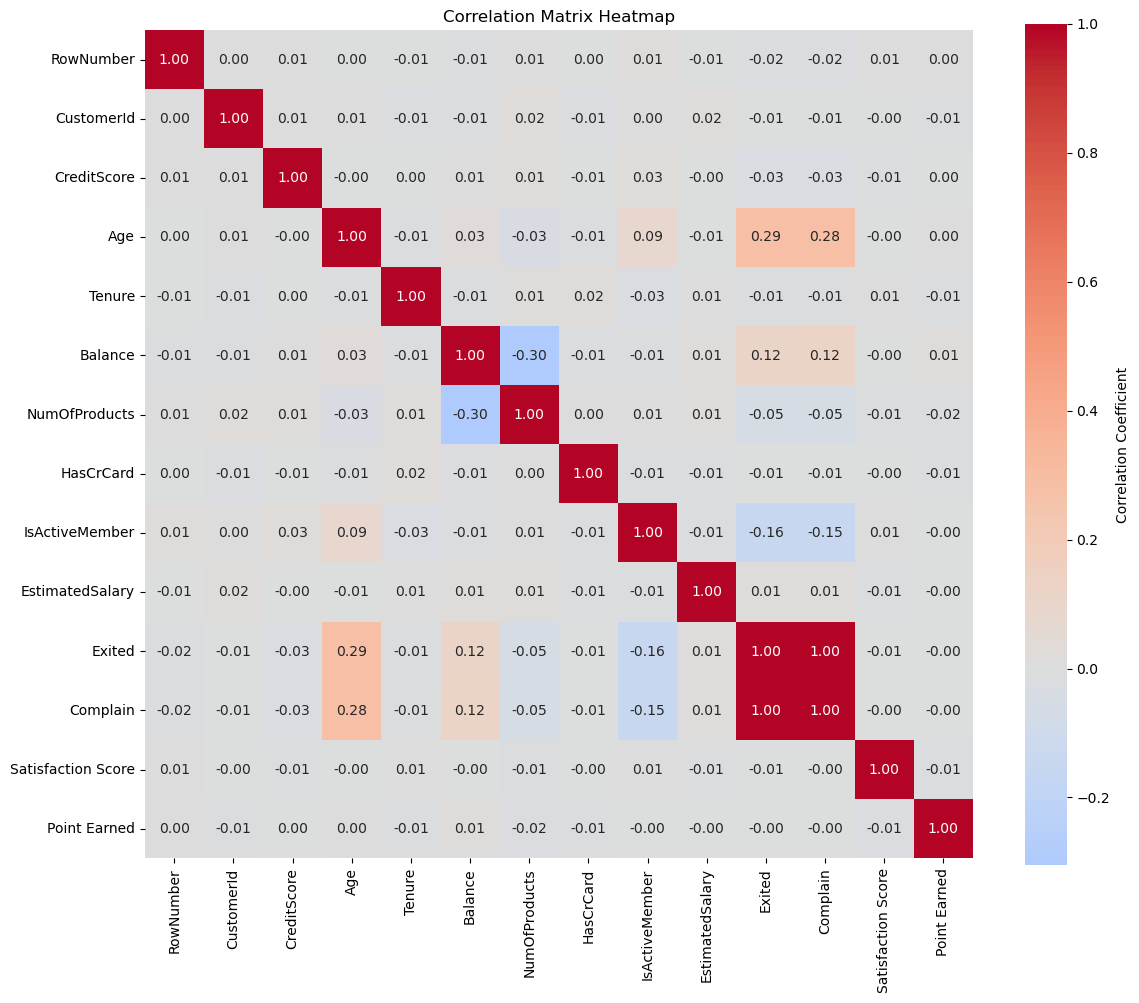

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_correlation_matrix(df):
    """
    Generate a correlation matrix to understand relationships between different attributes.
    """
    print("CORRELATION MATRIX ANALYSIS")
    print("=" * 50)
    
    # Select only numerical columns for correlation analysis
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    if len(numerical_cols) < 2:
        print("Not enough numerical columns for correlation analysis.")
        return
    
    print(f"Analyzing correlations between {len(numerical_cols)} numerical attributes:")
    for col in numerical_cols:
        print(f"  - {col}")
    
    # Calculate correlation matrix
    correlation_matrix = df[numerical_cols].corr()
    
    # Display correlation matrix as text
    print("\nCORRELATION MATRIX:")
    print("-" * 40)
    print(correlation_matrix.round(3))
    
    # Find strong correlations (above 0.7 or below -0.7)
    print("\nSTRONG CORRELATIONS (|r| > 0.7):")
    print("-" * 40)
    strong_correlations = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                strong_correlations.append((col1, col2, corr_value))
                print(f"  {col1} ↔ {col2}: {corr_value:.3f}")
    
    if not strong_correlations:
        print("  No strong correlations found.")
    
    # Find moderate correlations (between 0.3-0.7 or -0.3 to -0.7)
    print("\nMODERATE CORRELATIONS (0.3 < |r| < 0.7):")
    print("-" * 40)
    moderate_correlations = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if 0.3 < abs(corr_value) < 0.7:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                moderate_correlations.append((col1, col2, corr_value))
                print(f"  {col1} ↔ {col2}: {corr_value:.3f}")
    
    if not moderate_correlations:
        print("  No moderate correlations found.")
    
    # Generate correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Generate correlation summary
    print("\nCORRELATION SUMMARY:")
    print("-" * 40)
    print(f"Total attribute pairs analyzed: {len(numerical_cols) * (len(numerical_cols) - 1) // 2}")
    print(f"Strong correlations (|r| > 0.7): {len(strong_correlations)}")
    print(f"Moderate correlations (0.3 < |r| < 0.7): {len(moderate_correlations)}")
    
    # Save correlation matrix to CSV
    correlation_matrix.to_csv("correlation_matrix.csv")
    print(f"\nCorrelation matrix saved to 'correlation_matrix.csv'")

def main():
    """
    Load data and generate correlation matrix.
    """
    try:
        # Load the CSV file
        df = pd.read_csv("Customer-Churn-Records.csv")
        print("Data loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        
        # Generate correlation matrix
        generate_correlation_matrix(df)
        
    except FileNotFoundError:
        print("Error: Could not find 'Customer-Churn-Records.csv'")
        print("Make sure the file is in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


In [1]:
import pandas as pd
import numpy as np

def identify_data_quality_issues(df):
    """
    Identify various data quality issues in the dataset.
    """
    print("DATA QUALITY ANALYSIS")
    print("=" * 50)
    
    # Basic dataset information
    print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Total Data Points: {df.shape[0] * df.shape[1]:,}")
    
    quality_issues = {}
    
    # 1. Missing Values
    print("\n1. MISSING VALUES:")
    print("-" * 30)
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    
    if missing_values.sum() > 0:
        for col in missing_values[missing_values > 0].index:
            count = missing_values[col]
            percentage = missing_percentage[col]
            print(f"  {col}: {count} missing ({percentage:.1f}%)")
            quality_issues[f"missing_{col}"] = count
    else:
        print("  No missing values found.")
    
    # 2. Duplicate Rows
    print("\n2. DUPLICATE ROWS:")
    print("-" * 30)
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  Found {duplicates} duplicate rows ({(duplicates/len(df)*100):.1f}%)")
        quality_issues["duplicates"] = duplicates
    else:
        print("  No duplicate rows found.")
    
    # 3. Data Type Issues
    print("\n3. DATA TYPE ANALYSIS:")
    print("-" * 30)
    for col in df.columns:
        dtype = df[col].dtype
        non_null_count = df[col].count()
        print(f"  {col}: {dtype} ({non_null_count} non-null values)")
    
    # 4. Outliers (for numerical columns)
    print("\n4. OUTLIERS ANALYSIS:")
    print("-" * 30)
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    for col in numerical_cols:
        data = df[col].dropna()
        if len(data) > 0:
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(data)) * 100
            
            if outlier_count > 0:
                print(f"  {col}: {outlier_count} outliers ({outlier_percentage:.1f}%)")
                quality_issues[f"outliers_{col}"] = outlier_count
    
    if not any(key.startswith("outliers_") for key in quality_issues):
        print("  No significant outliers found.")
    
    # 5. Inconsistent Data
    print("\n5. INCONSISTENCY CHECK:")
    print("-" * 30)
    categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    
    for col in categorical_cols:
        unique_values = df[col].dropna().unique()
        if len(unique_values) <= 20:  # Only show for columns with reasonable number of categories
            print(f"  {col}: {len(unique_values)} unique values")
            # Check for potential inconsistencies (case variations, extra spaces)
            if df[col].dtype == 'object':
                stripped_values = df[col].dropna().str.strip().unique()
                if len(stripped_values) != len(unique_values):
                    print(f"    Warning: Potential whitespace issues")
                    quality_issues[f"whitespace_{col}"] = True
    
    # 6. Range Validation (for common fields)
    print("\n6. RANGE VALIDATION:")
    print("-" * 30)
    range_issues = []
    
    for col in numerical_cols:
        data = df[col].dropna()
        if len(data) > 0:
            min_val = data.min()
            max_val = data.max()
            
            # Check for negative values where they shouldn't be
            if 'age' in col.lower() and min_val < 0:
                range_issues.append(f"{col}: Negative age values found")
            elif 'balance' in col.lower() and min_val < 0:
                range_issues.append(f"{col}: Negative balance values found")
            elif 'score' in col.lower() and (min_val < 0 or max_val > 1000):
                range_issues.append(f"{col}: Score values outside expected range (0-1000)")
    
    if range_issues:
        for issue in range_issues:
            print(f"  {issue}")
    else:
        print("  No obvious range violations found.")
    
    return quality_issues

def address_data_quality_issues(df, quality_issues):
    """
    Address identified data quality issues.
    """
    print("\n" + "="*50)
    print("ADDRESSING DATA QUALITY ISSUES")
    print("=" * 50)
    
    df_cleaned = df.copy()
    changes_made = []
    
    # 1. Handle Missing Values
    missing_cols = [key.replace('missing_', '') for key in quality_issues.keys() if key.startswith('missing_')]
    if missing_cols:
        print("\n1. HANDLING MISSING VALUES:")
        print("-" * 30)
        
        for col in missing_cols:
            if df_cleaned[col].dtype in ['int64', 'float64']:
                # Fill numerical missing values with median
                median_val = df_cleaned[col].median()
                df_cleaned[col].fillna(median_val, inplace=True)
                print(f"  {col}: Filled {quality_issues[f'missing_{col}']} missing values with median ({median_val:.2f})")
                changes_made.append(f"Filled missing values in {col}")
            else:
                # Fill categorical missing values with mode
                mode_val = df_cleaned[col].mode()[0] if not df_cleaned[col].mode().empty else 'Unknown'
                df_cleaned[col].fillna(mode_val, inplace=True)
                print(f"  {col}: Filled {quality_issues[f'missing_{col}']} missing values with mode ('{mode_val}')")
                changes_made.append(f"Filled missing values in {col}")
    
    # 2. Remove Duplicates
    if 'duplicates' in quality_issues:
        print("\n2. REMOVING DUPLICATES:")
        print("-" * 30)
        before_count = len(df_cleaned)
        df_cleaned = df_cleaned.drop_duplicates()
        after_count = len(df_cleaned)
        removed = before_count - after_count
        print(f"  Removed {removed} duplicate rows")
        changes_made.append(f"Removed {removed} duplicate rows")
    
    # 3. Handle Outliers (cap extreme values)
    outlier_cols = [key.replace('outliers_', '') for key in quality_issues.keys() if key.startswith('outliers_')]
    if outlier_cols:
        print("\n3. HANDLING OUTLIERS:")
        print("-" * 30)
        
        for col in outlier_cols:
            data = df_cleaned[col]
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers instead of removing them
            outliers_before = len(data[(data < lower_bound) | (data > upper_bound)])
            df_cleaned[col] = np.clip(df_cleaned[col], lower_bound, upper_bound)
            print(f"  {col}: Capped {outliers_before} outliers to range [{lower_bound:.2f}, {upper_bound:.2f}]")
            changes_made.append(f"Capped outliers in {col}")
    
    # 4. Fix Whitespace Issues
    whitespace_cols = [key.replace('whitespace_', '') for key in quality_issues.keys() if key.startswith('whitespace_')]
    if whitespace_cols:
        print("\n4. FIXING WHITESPACE ISSUES:")
        print("-" * 30)
        
        for col in whitespace_cols:
            df_cleaned[col] = df_cleaned[col].str.strip()
            print(f"  {col}: Removed leading/trailing whitespace")
            changes_made.append(f"Fixed whitespace in {col}")
    
    # Summary
    print(f"\nCLEANING SUMMARY:")
    print("-" * 30)
    print(f"Original dataset: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Cleaned dataset: {df_cleaned.shape[0]} rows, {df_cleaned.shape[1]} columns")
    print(f"Changes made: {len(changes_made)}")
    
    for change in changes_made:
        print(f"  - {change}")
    
    return df_cleaned

def main():
    """
    Main function to identify and address data quality issues.
    """
    try:
        # Load the CSV file
        df = pd.read_csv("Customer-Churn-Records.csv")
        print("Data loaded successfully!")
        
        # Identify data quality issues
        quality_issues = identify_data_quality_issues(df)
        
        # Address the issues
        df_cleaned = address_data_quality_issues(df, quality_issues)
        
        # Save cleaned dataset
        df_cleaned.to_csv("Customer-Churn-Records-Cleaned.csv", index=False)
        print(f"\nCleaned dataset saved as 'Customer-Churn-Records-Cleaned.csv'")
        
        # Final quality check
        print(f"\nFINAL QUALITY CHECK:")
        print("-" * 30)
        final_missing = df_cleaned.isnull().sum().sum()
        final_duplicates = df_cleaned.duplicated().sum()
        print(f"Missing values: {final_missing}")
        print(f"Duplicate rows: {final_duplicates}")
        print("Data quality improvement completed!")
        
    except FileNotFoundError:
        print("Error: Could not find 'Customer-Churn-Records.csv'")
        print("Make sure the file is in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Data loaded successfully!
DATA QUALITY ANALYSIS
Dataset Shape: 10000 rows, 18 columns
Total Data Points: 180,000

1. MISSING VALUES:
------------------------------
  No missing values found.

2. DUPLICATE ROWS:
------------------------------
  No duplicate rows found.

3. DATA TYPE ANALYSIS:
------------------------------
  RowNumber: int64 (10000 non-null values)
  CustomerId: int64 (10000 non-null values)
  Surname: object (10000 non-null values)
  CreditScore: int64 (10000 non-null values)
  Geography: object (10000 non-null values)
  Gender: object (10000 non-null values)
  Age: int64 (10000 non-null values)
  Tenure: int64 (10000 non-null values)
  Balance: float64 (10000 non-null values)
  NumOfProducts: int64 (10000 non-null values)
  HasCrCard: int64 (10000 non-null values)
  IsActiveMember: int64 (10000 non-null values)
  EstimatedSalary: float64 (10000 non-null values)
  Exited: int64 (10000 non-null values)
  Complain: int64 (10000 non-null values)
  Satisfaction Score: int6

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu
from scipy.stats import pearsonr

def formulate_hypotheses():
    """
    Formulate hypotheses about customer churn factors.
    """
    print("CUSTOMER CHURN HYPOTHESIS FORMULATION")
    print("=" * 60)
    
    hypotheses = [
        {
            "name": "Age Hypothesis",
            "null": "There is no difference in age between churned and non-churned customers",
            "alternative": "Churned customers have different ages than non-churned customers",
            "test": "t-test"
        },
        {
            "name": "Balance Hypothesis", 
            "null": "Account balance does not affect customer churn",
            "alternative": "Customers with different account balances have different churn rates",
            "test": "t-test"
        },
        {
            "name": "Gender Hypothesis",
            "null": "Gender is independent of customer churn",
            "alternative": "Gender is associated with customer churn",
            "test": "chi-square"
        },
        {
            "name": "Geography Hypothesis",
            "null": "Geographic location is independent of customer churn", 
            "alternative": "Geographic location is associated with customer churn",
            "test": "chi-square"
        },
        {
            "name": "Credit Score Hypothesis",
            "null": "Credit score does not differ between churned and non-churned customers",
            "alternative": "Credit score differs between churned and non-churned customers", 
            "test": "t-test"
        }
    ]
    
    for i, hyp in enumerate(hypotheses, 1):
        print(f"\n{i}. {hyp['name']}:")
        print(f"   H0 (Null): {hyp['null']}")
        print(f"   H1 (Alternative): {hyp['alternative']}")
        print(f"   Statistical Test: {hyp['test']}")
    
    return hypotheses

def test_numerical_hypothesis(data, group_col, target_col, hypothesis_name):
    """
    Test hypothesis for numerical variables using t-test.
    """
    print(f"\n{hypothesis_name} - T-TEST ANALYSIS")
    print("-" * 50)
    
    # Separate groups
    group_0 = data[data[group_col] == 0][target_col].dropna()
    group_1 = data[data[group_col] == 1][target_col].dropna()
    
    # Descriptive statistics
    print(f"Non-churned customers (n={len(group_0)}):")
    print(f"  Mean {target_col}: {group_0.mean():.2f}")
    print(f"  Std Dev: {group_0.std():.2f}")
    
    print(f"Churned customers (n={len(group_1)}):")
    print(f"  Mean {target_col}: {group_1.mean():.2f}")
    print(f"  Std Dev: {group_1.std():.2f}")
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nT-Test Results:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significance level: α = 0.05")
    
    # Interpret results
    if p_value < 0.05:
        print(f"  ✓ REJECT NULL HYPOTHESIS (p < 0.05)")
        print(f"  Conclusion: Significant difference in {target_col} between groups")
        effect_size = abs(group_1.mean() - group_0.mean()) / np.sqrt(((group_1.std()**2 + group_0.std()**2) / 2))
        print(f"  Effect size (Cohen's d): {effect_size:.3f}")
    else:
        print(f"  ✗ FAIL TO REJECT NULL HYPOTHESIS (p ≥ 0.05)")
        print(f"  Conclusion: No significant difference in {target_col} between groups")
    
    return {"test": "t-test", "p_value": p_value, "significant": p_value < 0.05}

def test_categorical_hypothesis(data, group_col, target_col, hypothesis_name):
    """
    Test hypothesis for categorical variables using chi-square test.
    """
    print(f"\n{hypothesis_name} - CHI-SQUARE TEST ANALYSIS")
    print("-" * 50)
    
    # Create contingency table
    contingency_table = pd.crosstab(data[group_col], data[target_col])
    
    print("Contingency Table:")
    print(contingency_table)
    
    # Calculate percentages
    print("\nPercentages by row:")
    percentages = pd.crosstab(data[group_col], data[target_col], normalize='index') * 100
    print(percentages.round(1))
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-Square Test Results:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significance level: α = 0.05")
    
    # Interpret results
    if p_value < 0.05:
        print(f"  ✓ REJECT NULL HYPOTHESIS (p < 0.05)")
        print(f"  Conclusion: {group_col} and {target_col} are significantly associated")
        # Cramér's V for effect size
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
        print(f"  Effect size (Cramér's V): {cramers_v:.3f}")
    else:
        print(f"  ✗ FAIL TO REJECT NULL HYPOTHESIS (p ≥ 0.05)")
        print(f"  Conclusion: {group_col} and {target_col} are independent")
    
    return {"test": "chi-square", "p_value": p_value, "significant": p_value < 0.05}

def test_all_hypotheses(df):
    """
    Test all formulated hypotheses using appropriate statistical tests.
    """
    print("\n" + "="*60)
    print("STATISTICAL HYPOTHESIS TESTING")
    print("=" * 60)
    
    results = {}
    
    # Test 1: Age Hypothesis (Numerical - T-test)
    if 'Age' in df.columns and 'Exited' in df.columns:
        results['Age'] = test_numerical_hypothesis(df, 'Exited', 'Age', "AGE HYPOTHESIS")
    
    # Test 2: Balance Hypothesis (Numerical - T-test) 
    if 'Balance' in df.columns and 'Exited' in df.columns:
        results['Balance'] = test_numerical_hypothesis(df, 'Exited', 'Balance', "BALANCE HYPOTHESIS")
    
    # Test 3: Credit Score Hypothesis (Numerical - T-test)
    if 'CreditScore' in df.columns and 'Exited' in df.columns:
        results['CreditScore'] = test_numerical_hypothesis(df, 'Exited', 'CreditScore', "CREDIT SCORE HYPOTHESIS")
    
    # Test 4: Gender Hypothesis (Categorical - Chi-square)
    if 'Gender' in df.columns and 'Exited' in df.columns:
        results['Gender'] = test_categorical_hypothesis(df, 'Gender', 'Exited', "GENDER HYPOTHESIS")
    
    # Test 5: Geography Hypothesis (Categorical - Chi-square) 
    if 'Geography' in df.columns and 'Exited' in df.columns:
        results['Geography'] = test_categorical_hypothesis(df, 'Geography', 'Exited', "GEOGRAPHY HYPOTHESIS")
    
    return results

def summarize_findings(results):
    """
    Summarize all hypothesis test findings.
    """
    print("\n" + "="*60)
    print("HYPOTHESIS TESTING SUMMARY")
    print("=" * 60)
    
    significant_factors = []
    non_significant_factors = []
    
    for factor, result in results.items():
        if result['significant']:
            significant_factors.append(factor)
        else:
            non_significant_factors.append(factor)
    
    print(f"\nSIGNIFICANT FACTORS (p < 0.05):")
    print("-" * 30)
    if significant_factors:
        for factor in significant_factors:
            p_val = results[factor]['p_value']
            test_type = results[factor]['test']
            print(f"  ✓ {factor}: p = {p_val:.4f} ({test_type})")
    else:
        print("  No significant factors found")
    
    print(f"\nNON-SIGNIFICANT FACTORS (p ≥ 0.05):")
    print("-" * 30)
    if non_significant_factors:
        for factor in non_significant_factors:
            p_val = results[factor]['p_value']
            test_type = results[factor]['test']
            print(f"  ✗ {factor}: p = {p_val:.4f} ({test_type})")
    else:
        print("  All factors are significant")
    
    print(f"\nCONCLUSIONS:")
    print("-" * 30)
    print(f"• Total factors tested: {len(results)}")
    print(f"• Significant associations: {len(significant_factors)}")
    print(f"• Non-significant associations: {len(non_significant_factors)}")
    
    if significant_factors:
        print(f"\nThe following factors show statistically significant")
        print(f"associations with customer churn:")
        for factor in significant_factors:
            print(f"  - {factor}")
        print(f"\nThese factors should be prioritized in churn prevention strategies.")

def main():
    """
    Main function to test customer churn hypotheses.
    """
    try:
        # Load the CSV file
        df = pd.read_csv("Customer-Churn-Records.csv")
        print("Data loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        
        # Formulate hypotheses
        hypotheses = formulate_hypotheses()
        
        # Test all hypotheses
        results = test_all_hypotheses(df)
        
        # Summarize findings
        summarize_findings(results)
        
    except FileNotFoundError:
        print("Error: Could not find 'Customer-Churn-Records.csv'")
        print("Make sure the file is in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Data loaded successfully!
Dataset shape: (10000, 18)
CUSTOMER CHURN HYPOTHESIS FORMULATION

1. Age Hypothesis:
   H0 (Null): There is no difference in age between churned and non-churned customers
   H1 (Alternative): Churned customers have different ages than non-churned customers
   Statistical Test: t-test

2. Balance Hypothesis:
   H0 (Null): Account balance does not affect customer churn
   H1 (Alternative): Customers with different account balances have different churn rates
   Statistical Test: t-test

3. Gender Hypothesis:
   H0 (Null): Gender is independent of customer churn
   H1 (Alternative): Gender is associated with customer churn
   Statistical Test: chi-square

4. Geography Hypothesis:
   H0 (Null): Geographic location is independent of customer churn
   H1 (Alternative): Geographic location is associated with customer churn
   Statistical Test: chi-square

5. Credit Score Hypothesis:
   H0 (Null): Credit score does not differ between churned and non-churned customers
 

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def design_churn_experiment():
    """
    Design a controlled experiment to test customer churn reduction hypothesis.
    """
    print("CONTROLLED EXPERIMENT DESIGN FOR CUSTOMER CHURN REDUCTION")
    print("=" * 70)

    # Select hypothesis to test
    selected_hypothesis = {
        "name": "Personalized Engagement Hypothesis",
        "hypothesis": "Customers with low account balances are more likely to churn, and personalized financial advice will reduce their churn rate",
        "rationale": "Low balance customers may feel undervalued. Proactive engagement can improve retention."
    }

    print(f"SELECTED HYPOTHESIS:")
    print(f"Name: {selected_hypothesis['name']}")
    print(f"Hypothesis: {selected_hypothesis['hypothesis']}")
    print(f"Rationale: {selected_hypothesis['rationale']}")

    return selected_hypothesis

def create_experimental_design():
    """
    Create detailed experimental design with control and treatment groups.
    """
    print(f"\nEXPERIMENTAL DESIGN")
    print("=" * 50)

    experimental_design = {
        "objective": "Test if personalized financial advice reduces churn among low-balance customers",
        "target_population": "Customers with account balance < $50,000",
        "sample_size": 2000,
        "control_group": {
            "size": 1000,
            "description": "Low-balance customers receiving standard service",
            "treatment": "No additional intervention (business as usual)"
        },
        "treatment_group": {
            "size": 1000,
            "description": "Low-balance customers receiving personalized financial advice",
            "treatment": "Monthly personalized financial consultations + custom investment recommendations"
        },
        "duration": "6 months",
        "randomization": "Stratified random sampling by geography and age group"
    }

    print(f"Objective: {experimental_design['objective']}")
    print(f"Target Population: {experimental_design['target_population']}")
    print(f"Total Sample Size: {experimental_design['sample_size']} customers")

    print(f"\nCONTROL GROUP:")
    print(f"  Size: {experimental_design['control_group']['size']} customers")
    print(f"  Description: {experimental_design['control_group']['description']}")
    print(f"  Treatment: {experimental_design['control_group']['treatment']}")

    print(f"\nTREATMENT GROUP:")
    print(f"  Size: {experimental_design['treatment_group']['size']} customers")
    print(f"  Description: {experimental_design['treatment_group']['description']}")
    print(f"  Treatment: {experimental_design['treatment_group']['treatment']}")

    print(f"\nEXPERIMENT DURATION: {experimental_design['duration']}")
    print(f"RANDOMIZATION METHOD: {experimental_design['randomization']}")

    return experimental_design

def define_metrics_and_timeline():
    """
    Define primary and secondary metrics with measurement timeline.
    """
    print(f"\nMETRICS AND MEASUREMENT PLAN")
    print("=" * 50)

    metrics = {
        "primary_metric": {
            "name": "Churn Rate",
            "definition": "Percentage of customers who close their accounts during the experiment period",
            "measurement": "Monthly tracking, final measurement at 6 months",
            "success_criteria": "≥20% reduction in churn rate compared to control group"
        },
        "secondary_metrics": [
            {
                "name": "Customer Satisfaction Score",
                "definition": "Average satisfaction rating (1-10 scale)",
                "measurement": "Survey at 3 months and 6 months",
                "target": "≥1 point increase vs. control group"
            },
            {
                "name": "Account Balance Growth",
                "definition": "Average percentage increase in account balance",
                "measurement": "Monthly tracking",
                "target": "≥15% higher growth vs. control group"
            },
            {
                "name": "Product Adoption Rate",
                "definition": "Percentage of customers adopting new financial products",
                "measurement": "Monthly tracking",
                "target": "≥30% higher adoption vs. control group"
            },
            {
                "name": "Customer Engagement Score",
                "definition": "Frequency of customer interactions (calls, emails, app usage)",
                "measurement": "Weekly tracking",
                "target": "≥25% increase vs. control group"
            }
        ]
    }

    print(f"PRIMARY METRIC:")
    pm = metrics["primary_metric"]
    print(f"  Name: {pm['name']}")
    print(f"  Definition: {pm['definition']}")
    print(f"  Measurement: {pm['measurement']}")
    print(f"  Success Criteria: {pm['success_criteria']}")

    print(f"\nSECONDARY METRICS:")
    for i, metric in enumerate(metrics["secondary_metrics"], 1):
        print(f"  {i}. {metric['name']}")
        print(f"     Definition: {metric['definition']}")
        print(f"     Measurement: {metric['measurement']}")
        print(f"     Target: {metric['target']}")

    return metrics

def create_implementation_timeline():
    """
    Create detailed implementation timeline for the experiment.
    """
    print(f"\nIMPLEMENTATION TIMELINE")
    print("=" * 50)

    start_date = datetime(2025, 10, 1)
    timeline = []

    # Pre-experiment phase
    timeline.append({"phase": "Preparation", "start": start_date - timedelta(days=30),
                    "duration": "4 weeks", "activities": [
                        "Customer segmentation and selection",
                        "Random assignment to control/treatment groups",
                        "Baseline data collection",
                        "Staff training for treatment delivery",
                        "System setup for tracking metrics"
                    ]})

    # Experiment phases
    timeline.append({"phase": "Month 1-2", "start": start_date,
                    "duration": "8 weeks", "activities": [
                        "Launch treatment interventions",
                        "Begin weekly engagement tracking",
                        "First round of personalized consultations",
                        "Monitor early metrics and compliance"
                    ]})

    timeline.append({"phase": "Month 3-4", "start": start_date + timedelta(days=56),
                    "duration": "8 weeks", "activities": [
                        "Mid-point satisfaction surveys",
                        "Continue treatment delivery",
                        "Interim analysis of primary metrics",
                        "Adjust intervention if needed"
                    ]})

    timeline.append({"phase": "Month 5-6", "start": start_date + timedelta(days=112),
                    "duration": "8 weeks", "activities": [
                        "Final round of interventions",
                        "End-of-study satisfaction surveys",
                        "Complete data collection",
                        "Prepare for final analysis"
                    ]})

    timeline.append({"phase": "Analysis", "start": start_date + timedelta(days=168),
                    "duration": "2 weeks", "activities": [
                        "Statistical analysis of results",
                        "Effect size calculations",
                        "Report preparation",
                        "Recommendations for rollout"
                    ]})

    for phase in timeline:
        print(f"\n{phase['phase']} ({phase['start'].strftime('%Y-%m-%d')} - {phase['duration']}):")
        for activity in phase['activities']:
            print(f"  • {activity}")

    return timeline

def calculate_sample_size_and_power():
    """
    Calculate required sample size and statistical power for the experiment.
    """
    print(f"\nSTATISTICAL POWER ANALYSIS")
    print("=" * 50)

    # Assumptions for power calculation
    assumptions = {
        "baseline_churn_rate": 0.20,  # 20% churn rate in control group
        "target_reduction": 0.20,     # 20% relative reduction (4 percentage points)
        "significance_level": 0.05,   # α = 0.05
        "power": 0.80,               # 80% power
        "two_sided_test": True
    }

    # Expected rates
    control_rate = assumptions["baseline_churn_rate"]
    treatment_rate = control_rate * (1 - assumptions["target_reduction"])
    effect_size = abs(control_rate - treatment_rate)

    print(f"ASSUMPTIONS:")
    print(f"  Baseline churn rate (control): {control_rate:.1%}")
    print(f"  Target churn rate (treatment): {treatment_rate:.1%}")
    print(f"  Expected effect size: {effect_size:.1%}")
    print(f"  Significance level (α): {assumptions['significance_level']}")
    print(f"  Statistical power: {assumptions['power']:.0%}")

    # Simplified sample size calculation (rule of thumb)
    # For two proportions with 80% power and α=0.05
    estimated_n_per_group = 1000  # Conservative estimate

    print(f"\nSAMPLE SIZE CALCULATION:")
    print(f"  Estimated sample size per group: {estimated_n_per_group}")
    print(f"  Total sample size: {estimated_n_per_group * 2}")
    print(f"  Safety margin included: 10% for potential dropouts")

    return assumptions

def create_analysis_plan():
    """
    Create statistical analysis plan for the experiment.
    """
    print(f"\nSTATISTICAL ANALYSIS PLAN")
    print("=" * 50)

    analysis_plan = {
        "primary_analysis": {
            "method": "Two-proportion z-test",
            "comparison": "Treatment group churn rate vs. Control group churn rate",
            "hypothesis": "H0: p_treatment = p_control vs. H1: p_treatment ≠ p_control",
            "significance_level": "α = 0.05"
        },
        "secondary_analyses": [
            "T-test for continuous metrics (satisfaction scores, balance growth)",
            "Chi-square test for categorical outcomes (product adoption)",
            "Time-to-event analysis for churn timing",
            "Subgroup analysis by customer demographics"
        ],
        "effect_size_measures": [
            "Relative risk reduction",
            "Number needed to treat (NNT)",
            "Cohen's d for continuous variables"
        ]
    }

    print(f"PRIMARY ANALYSIS:")
    pa = analysis_plan["primary_analysis"]
    print(f"  Method: {pa['method']}")
    print(f"  Comparison: {pa['comparison']}")
    print(f"  Hypothesis: {pa['hypothesis']}")
    print(f"  Significance Level: {pa['significance_level']}")

    print(f"\nSECONDARY ANALYSES:")
    for analysis in analysis_plan["secondary_analyses"]:
        print(f"  • {analysis}")

    print(f"\nEFFECT SIZE MEASURES:")
    for measure in analysis_plan["effect_size_measures"]:
        print(f"  • {measure}")

    return analysis_plan

def simulate_experiment_data():
    """
    Simulate what the experiment data might look like.
    """
    print(f"\nEXPERIMENT DATA SIMULATION")
    print("=" * 50)

    np.random.seed(42)

    # Simulate customer data
    n_per_group = 1000

    # Control group
    control_data = {
        'customer_id': [f'C{i:04d}' for i in range(1, n_per_group + 1)],
        'group': ['Control'] * n_per_group,
        'baseline_balance': np.random.normal(30000, 15000, n_per_group),
        'churn': np.random.binomial(1, 0.20, n_per_group),  # 20% churn rate
        'satisfaction': np.random.normal(6.5, 1.5, n_per_group),
        'engagement_score': np.random.normal(50, 15, n_per_group)
    }

    # Treatment group
    treatment_data = {
        'customer_id': [f'T{i:04d}' for i in range(1, n_per_group + 1)],
        'group': ['Treatment'] * n_per_group,
        'baseline_balance': np.random.normal(30000, 15000, n_per_group),
        'churn': np.random.binomial(1, 0.16, n_per_group),  # 16% churn rate (20% reduction)
        'satisfaction': np.random.normal(7.2, 1.4, n_per_group),  # Higher satisfaction
        'engagement_score': np.random.normal(62, 18, n_per_group)  # Higher engagement
    }

    # Combine data
    df_control = pd.DataFrame(control_data)
    df_treatment = pd.DataFrame(treatment_data)
    df_experiment = pd.concat([df_control, df_treatment], ignore_index=True)

    # Calculate key metrics
    control_churn = df_control['churn'].mean()
    treatment_churn = df_treatment['churn'].mean()
    churn_reduction = (control_churn - treatment_churn) / control_churn

    print(f"SIMULATED RESULTS:")
    print(f"  Control group churn rate: {control_churn:.1%}")
    print(f"  Treatment group churn rate: {treatment_churn:.1%}")
    print(f"  Relative churn reduction: {churn_reduction:.1%}")
    print(f"  Sample size per group: {n_per_group}")

    # Statistical significance test
    from scipy.stats import chi2_contingency

    # Create contingency table
    churn_table = pd.crosstab(df_experiment['group'], df_experiment['churn'])
    chi2, p_value, dof, expected = chi2_contingency(churn_table)

    print(f"\nSTATISTICAL TEST RESULTS:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"  ✓ STATISTICALLY SIGNIFICANT (p < 0.05)")
        print(f"  Conclusion: Treatment significantly reduces churn")
    else:
        print(f"  ✗ NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)")
        print(f"  Conclusion: No significant difference detected")

    return df_experiment

def main():
    """
    Main function to design the controlled experiment.
    """
    print("CUSTOMER CHURN REDUCTION EXPERIMENT DESIGN")
    print("Date:", datetime.now().strftime("%Y-%m-%d"))

    # Design components
    hypothesis = design_churn_experiment()
    design = create_experimental_design()
    metrics = define_metrics_and_timeline()
    timeline = create_implementation_timeline()
    power_analysis = calculate_sample_size_and_power()
    analysis_plan = create_analysis_plan()

    # Simulate experiment
    simulated_data = simulate_experiment_data()

    print(f"\n" + "="*70)
    print("EXPERIMENT DESIGN SUMMARY")
    print("=" * 70)
    print(f"✓ Hypothesis formulated and justified")
    print(f"✓ Control and treatment groups defined")
    print(f"✓ Sample size calculated (2,000 customers)")
    print(f"✓ Duration planned (6 months)")
    print(f"✓ Primary and secondary metrics specified")
    print(f"✓ Implementation timeline created")
    print(f"✓ Statistical analysis plan prepared")
    print(f"✓ Expected outcomes simulated")

    print(f"\nEXPERIMENT READY FOR IMPLEMENTATION!")

if __name__ == "__main__":
    main()


CUSTOMER CHURN REDUCTION EXPERIMENT DESIGN
Date: 2025-09-20
CONTROLLED EXPERIMENT DESIGN FOR CUSTOMER CHURN REDUCTION
SELECTED HYPOTHESIS:
Name: Personalized Engagement Hypothesis
Hypothesis: Customers with low account balances are more likely to churn, and personalized financial advice will reduce their churn rate
Rationale: Low balance customers may feel undervalued. Proactive engagement can improve retention.

EXPERIMENTAL DESIGN
Objective: Test if personalized financial advice reduces churn among low-balance customers
Target Population: Customers with account balance < $50,000
Total Sample Size: 2000 customers

CONTROL GROUP:
  Size: 1000 customers
  Description: Low-balance customers receiving standard service
  Treatment: No additional intervention (business as usual)

TREATMENT GROUP:
  Size: 1000 customers
  Description: Low-balance customers receiving personalized financial advice
  Treatment: Monthly personalized financial consultations + custom investment recommendations

EX